In [24]:
from gensim.models import FastText
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fasttext

In [41]:
corpus_fname = 'natapann_data.txt'
model_fname = 'fasttext'


print('corpus 생성')
corpus = [sent.strip().split(" ")for sent in tqdm(open(corpus_fname, 'r', encoding='utf-8').readlines())]

print("학습 중")
model = FastText(corpus, vector_size=100, window=5, min_count=5, workers=4, sg=1)
model.save(model_fname)
print('완료')

  0%|                                                                                        | 0/10701 [00:00<?, ?it/s]

corpus 생성


100%|██████████████████████████████████████████████████████████████████████████| 10701/10701 [00:03<00:00, 3357.97it/s]


학습 중
완료


In [27]:
loaded_model = FastText.load("fasttext")
print(model.wv.vectors.shape)

(17036, 100)


In [28]:
print(loaded_model.wv.most_similar("스우파", topn=10))

[('노제', 0.9820411205291748), ('티저', 0.9783189296722412), ('로잘린', 0.9782274961471558), ('리정', 0.9745947122573853), ('미쳤다', 0.9729905128479004), ('ㄹㅈㄷ', 0.971329391002655), ('이채연', 0.9702030420303345), ('서치', 0.9700813889503479), ('직캠', 0.968477189540863), ('역대급', 0.9682524800300598)]


In [29]:
print(loaded_model.wv.most_similar("재난지원금", topn=10))

[('재난지원금을', 0.9956145882606506), ('뭣하러', 0.9916195273399353), ('입맛에', 0.9913861155509949), ('옳지', 0.9902035593986511), ('대접을', 0.9899418950080872), ('구지', 0.9897322058677673), ('욕심', 0.9897087216377258), ('기본은', 0.9896602630615234), ('묶여', 0.9888975620269775), ('맹세코', 0.9888957142829895)]


# 각 연관 단어가 포함된 텍스트 덩어리의 극성값 

연관 단어를 10-15개 추출하고, 새로운용어 + 연관단어 두가지가 모두 포함된 문장들만 추출하여 그 문장들의 감성분석을 진행하여 극성값을 추출한다. 

In [1]:
import re
import io
import json
import csv
import openpyxl
import pandas as pd
import numpy as np
import kss
import ast
from konlpy.tag import Komoran
from IPython.core.display import display, HTML
from konlpy.tag import Okt

In [2]:
fkey = '스우파'
key = '모니카'

In [3]:
final = pd.DataFrame(columns = ['contents'])

f = pd.read_csv('natepann_data.csv')

is_key = (f['본문'].str.contains(fkey, na=False) | f['제목'].str.contains(fkey, na=False)) & (f['본문'].str.contains(key, na=False) | f['제목'].str.contains(key, na=False))

f_key = f[is_key]
f_key = f_key.reset_index()
print(f_key)

final_key = pd.DataFrame(columns = ['tokenized'])

komoran = Komoran()

for i in range(len(f_key)):
    try:
        st = f_key.loc[i, '제목']
        final_key.loc[i, 'tokenized'] = str(st)
        ct = f_key.loc[i, '본문']
        final_key.loc[i, 'tokenized'] += str(ct)
        
    except KeyError:
        print("error")

keyword_content = pd.DataFrame(columns = ['content','positive', 'negative', 'neutral'])


for i in range(len(final_key)):
    try:
        fc = final_key.loc[i, 'tokenized']
        
        if i == 0:
            keyword_content.loc[0,'content'] = fc
        else:
            keyword_content.loc[0,'content'] += fc
        
    except KeyError:
        print("error")

keyword_content

# 감성사전에서 감성분석
f = open('SentiWord_Dict.txt', 'r', -1, 'utf-8')
lines = f.readlines()

score_dict = []

for line in lines:
    line_splited = line.split()
    score = int(line_splited[-1])
    word = ''
    for frac in line_splited[:-1]:
        word = word + ' ' + frac
    
    word = word[1:]
    score_dict.append([word, score])
    
keyword_content['positive'] = 0
keyword_content['negative'] = 0
keyword_content['neutral'] = 0

if keyword_content.empty:
    print("사전과 비교할 조건에 맞는 내용 없음")

else:
    keyword_content.loc[0, 'content'] = str(komoran.nouns(keyword_content.loc[0, 'content']))


    stopwords = ['하다', '없다', '있다', '되다', '아니다', '같다', '이다', '않다', '그렇다', 
                 '이렇다', '싶다', '다', '것', '그', '이', '거', '니다']


    pos_list = ast.literal_eval(keyword_content.loc[0, 'content'])

    final = []

    for j in range(len(pos_list)):
        if pos_list[j] not in stopwords:
            final.append(pos_list[j])

    keyword_content.loc[0, 'content'] = str(final)

    # 감성사전에서 감성분석
    f = open('SentiWord_Dict.txt', 'r', -1, 'utf-8')
    lines = f.readlines()

    score_dict = []

    for line in lines:
        line_splited = line.split()
        score = int(line_splited[-1])
        word = ''
        for frac in line_splited[:-1]:
            word = word + ' ' + frac

            word = word[1:]
            score_dict.append([word, score])

    keyword_content.insert(0, "Keyword", key)

    tokens = ast.literal_eval(keyword_content.loc[0, 'content'])

    try:
        for token in tokens:
            for dict_word in score_dict:
                if dict_word[0] == token:
                    if dict_word[1] > 0:
                        keyword_content.loc[0, 'positive'] += dict_word[1]
                    elif dict_word[1] < 0:
                        keyword_content.loc[0, 'negative'] += dict_word[1]
                    else:
                        keyword_content.loc[0, 'negative'] += 1 #중립어는 개수 세기    
    except KeyError:
        print("error")

print("연관 단어 :" + fkey)
keyword_content[keyword_content.columns.difference(['content'])]

    index                              제목  \
0    9006                  스우파갤도 태용 ㅈㄴ욕하네   
1    9284                 솔직히 그냥 넘어가면 안돼지   
2    9317             스우파 립제이 로잘린 과거 궁금하다   
3    9409                    이거 로잘린 과거 맞아   
4    9443                    스우파 출연진들 닮은꼴   
5    9460                     스우파 비주얼 삼대장   
6    9629                         스우파 모니카   
7    9646               여돌 그룹별 남덕몰이멤여덕몰이멤   
8    9745                스우파 댄서들 현재 활동 상황   
9    9770            스우파 이상하게 과몰입하는 애들때문에   
10   9926                 헐 이사배가 노제 커버한거봄   
11   9945                메가크루 미션 누가 제일 좋음   
12  10016  모니카쌤 피셜 프라우드먼 메가크루 영상 해석 같이 보자   
13  10090           걸플이 빅스가 만든 무대 그대로 표절함   
14  10132                    는 갈수록 한계 느껴짐   
15  10194                    흥미로운 사실 알려줄게   
16  10453             같은 머리하고 춤 춘 모니카랑 노제   

                                                   본문  
0   개웃기다 판만 태용 학폭 중고나라 쉴드치는거 귀신같이아네모니카 태용 스우파 보아 이채연   
1   끌올 ㅅㅊ 방탄소년단 정국 지민 뷔 세븐틴 블랙핑크 제니 로제 지수 이달의소녀 레드...  
2   대충 보면 오핸지 뭔진 모르겠지

,Keyword,negative,neutral,positive
0,모니카,-55,0,91


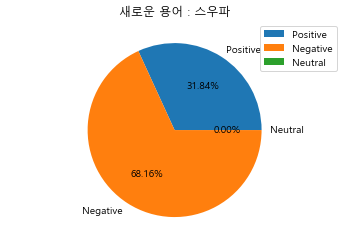

스우파의 극성값 = -1
예시 문장 1: 개웃기다 판만 태용 학폭 중고나라 쉴드치는거 귀신같이아네모니카 태용 스우파 보아 이채연 
예시 문장 2: 대충 보면 오핸지 뭔진 모르겠지만 로잘린이 립제이 뒷말하다 걸려서 나간거같은데 본인 입으로도 많은 댄서들한테 욕먹었다했고ㅋㅋ 근데 또 사실이랑 다를 수도 있는거니까 ㄹㅇ궁금하다 누가 진상좀 자세히 풀어줬으면그리고 모니카 립제이 가비 리헤이 화이팅


In [6]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager, rc
import platform

#iteration 만들기 이전 => 수동 합계

#한글 꺠짐 처리
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False
pos = 12 + 12 + 6 + 6+ 2 + 13 + 13
neg = -21 -23 -16 -17 -14 -17 -29
nneg = str(neg).replace("-", "")
neu = 0

size = [pos, nneg, neu]

label = ['Positive','Negative', 'Neutral']

plt.axis('equal')
plt.pie(x=size, labels=label, autopct='%.2f%%')

plt.title("새로운 용어 : " + fkey)
plt.legend(loc="upper right")
plt.show()


p = pos / (pos + int(nneg))*100
n = int(nneg) / (pos + int(nneg))*100
total = p - n

if total <= 10 and total >= -10:
    Senti = 0
elif total < -10 and total >= -50:
    Senti = -1
elif total < -50:
    Senti = -2
elif total > 10 and total<= 50:
    Senti = 1
elif total > 50:
    Senti = 2

print(str(fkey) + "의 극성값 = " + str(Senti))

print("예시 문장 1: " + f_key.loc[0, '본문'])
print("예시 문장 2: " + f_key.loc[2, '본문'])

# 각 연관 단어 1:1 사전 비교 극성값

각 단어별 사전과 비교시 아예 검색이 되지 않는 경우가 너무 많음, 형태적으로 사전에 등록되지 않은 내용이 많아서 1:1 매핑이 어려움.

In [37]:
Similar = []
similar_word_list = list(loaded_model.wv.most_similar("스우파", topn=100)) 

for i in range(len(similar_word_list)):
    temp_str = similar_word_list[i][0].__str__()
    Similar.append(temp_str)
    
print(Similar)

['모니카', '립제이', '로잘린', '라치카', '웨이비', '시미즈', '허니제이', '마스카라', '올라온', '김민주', '광고', '첫번째', '환승연애', '팬들이', '안유진', '떠난', '끝나고', '이채연', '시간에', '재계약을', '리헤이', '하루종일', '데리고', '가게를', '걸서위', '반응이', '아이들이', '한국에', '사서', '역시', '하려고', '당일', '사랑해', '인스타', '최유정', '방금', '나은은', '없다는', '보아', '몰라서', '말고도', '이유를', '엠마', '한번뿐인', '바빠서', '방법이', '보이는', '하도', '있도록', '중간중간', '잘린', '따라', '갖고', '베트남', '예쁜', '만원을', '프라우드먼', '아직까지', '받아', '화이팅', '지원을', '서울대', '아이는', '음식을', '사이', '보니까', '사진도', '나머지', '마름', '블로그', '당연히', '초반', '해야할지', '평범한', '추천', '없던', '좋겠다', '만드는', '병원에서', '가까이', '코로나가', '년간', '기다리고', '봐서', '이라', '좋지', '애기', '해주고', '베트남에', '판에', '그나마', '안됨', '년동안', '시댁에서', '마크', '마시고', '한국으로', '대부분', '하루', '백신을']


In [38]:
word_senti = pd.DataFrame(columns = ['positive', 'negative', 'neutral'])

In [39]:
w= '바빠서'
word_senti.insert(0, "Word", w)

In [40]:
word_senti.loc[0, 'positive'] = 0
word_senti.loc[0, 'negative'] = 0
word_senti.loc[0, 'neutral'] = 0

try:
    for dict_word in score_dict:
        if dict_word[0] == w:
            if dict_word[1] > 0:
                word_senti.loc[0, 'positive'] += dict_word[1]
            elif dict_word[1] < 0:
                word_senti.loc[0, 'negative'] += dict_word[1]
            else:
                word_senti.loc[0, 'neutral'] += 1 #중립어는 개수 세기    
except KeyError:
    print("error")

In [41]:
word_senti[word_senti.columns.difference(['Word'])]

,negative,neutral,positive
0,0,0,0
